# Assignment 2
#### Social data analysis and visualization 02806
#### Technical University of Denmark

For the peergrader, please make sure your CSV file for the SFPD dataset is in the same directory as this notebook if you for some reason need to re-run.

In [1]:
# This cell is included to show what libraries are imported and used in the assignment
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import geoplotlib
import math

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from geoplotlib.utils import BoundingBox

%matplotlib inline

### Assignment 2A: One scatter plot and two datasets

*__Explain in your own words why you think I want the axes to be the same for both years?__*

When the axes are the same for both years the reader/viewer of the visualization gets a clear idea of how many crimes were commited in the years relative to each. Basically it shows the viewer in which year there were commited more prostitution and vehicle theft crimes without the need to consider the axes in detail, so the overview of the data is better. If the axes were not the same and change according to the data from year 2003 and from 2005 you would have to study the values on the axes and not the data inside the plot. An important feature of visualizations is Overview first, this is achieved when the axes does not change.

### Assignment 2B: Visualizing geodata

In this section we performed the K-means clustering method on the prostitution data.

In [2]:
with open('SFPD_Incidents_-_from_1_January_2003.csv','r') as infile:
    
    focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY',
                   'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT',
                   'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT']
    
    data = {
                "lat": [],
                "lon": [],
                "Category": [],
                "Date": [],
                "Time": [],
                "PdDistrict": [],  
                "Day": []
    }
    
    for line in csv.DictReader( infile, delimiter=","):
        if(float(line["Y"]) > 40): #One datapoint of "lat" is 90.0 so lets remove it
            continue
            
        try:
            data["lat"].append(float(line["Y"]))
            data["lon"].append(float(line["X"]))
            data["Category"].append(line["Category"])
            data["Date"].append(line["Date"])
            data["PdDistrict"].append(line["PdDistrict"])
            
            #data["Time"].append(line["Time"])
            hours = float(line["Time"].split(":")[0])
            minutes =  hours*60 + float(line["Time"].split(":")[1])
            data["Time"].append(minutes)
            
            # Extract day from dates
            day = int(line["Date"].split("/")[0])
            data["Day"].append(day)
            
        except:
            print(line)

In [3]:
#Bounding box, defined using google maps
x_min = -122.595317
x_max = -122.286380
y_max = 37.8326
y_min = 37.7040

#Initialize the category
prostitution_geo = {
    "lat": [],
    "lon": []
}

focuscrimes_knn = ['PROSTITUTION']

#Divide the original data into the three focuscrimes so we can plot it
for idx in range(len(data["Category"])):
    if(data["Category"][idx] == focuscrimes_knn[0]):
        prostitution_geo["lat"].append(data["lat"][idx])
        prostitution_geo["lon"].append(data["lon"][idx])

#Print the size of each category
print("Number of crimes in each category: \nProstitution: %d" % (len(prostitution_geo["lat"])))

Number of crimes in each category: 
Prostitution: 16162


*__Visualize the prostitution data (e.g. by plotting it on a map)__*

In [4]:
#Set up a bounding box:
bbox = BoundingBox(north=y_max, west=x_min, south=y_min, east=x_max)

#Plot using Kernel Density Estimation
geoplotlib.kde(prostitution_geo, bw=6, cut_below=1e-4)
geoplotlib.set_bbox(bbox)
print("Prostitution Crimes")
geoplotlib.inline()

Prostitution Crimes
('smallest non-zero count', 4.9755799111408007e-10)
('max count:', 8.4612274394437748)


*__Train models of K=2,…,10 on the prostitution data.__*

In [5]:
# Train models
features = np.matrix([prostitution_geo["lat"], prostitution_geo["lon"]]).transpose()

for K in range(2,11):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(features)

# Print values from last fitted model (K=10)
print kmeans.labels_
print kmeans.cluster_centers_
print kmeans.inertia_

[4 6 6 ..., 6 1 1]
[[  37.78626882 -122.41734463]
 [  37.75910174 -122.41643614]
 [  37.71821986 -122.47527816]
 [  37.79083017 -122.42165764]
 [  37.76172612 -122.47656106]
 [  37.73029391 -122.39692676]
 [  37.78547986 -122.40357636]
 [  37.76372022 -122.41565241]
 [  37.75480487 -122.4989759 ]
 [  37.72155881 -122.44047269]]
0.293078315327


*__Explore how the total squared error changes as a function of K and identify what you think is the right number of clusers based on the knee-point in the squared error plot.__*

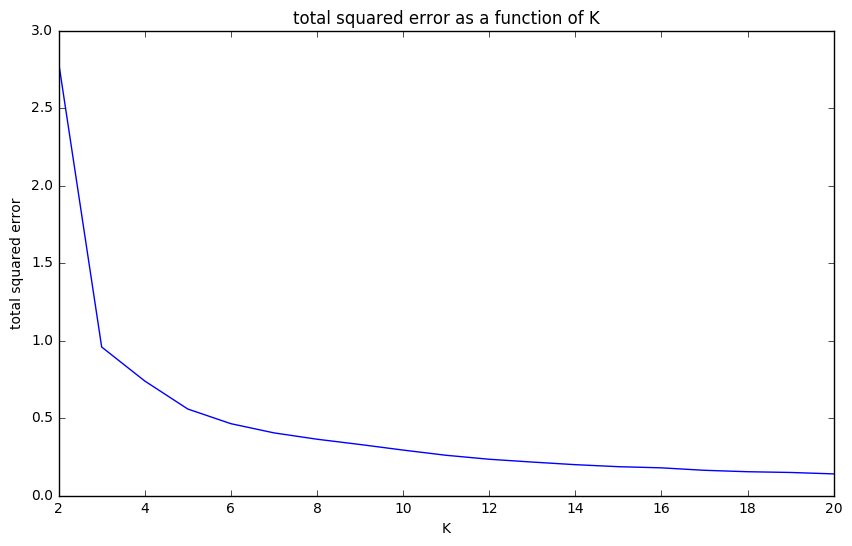

In [6]:
K_values = range(2,21)
tot_sq_errors = [0 for K in K_values]

# We fit the models one by one and compute total squared error for each one
for K in K_values:
    # Fit model
    kmeans = KMeans(n_clusters=K, random_state=0).fit(features)
    # Compute total squared error
    for idx,point in enumerate(features):
        label = kmeans.labels_[idx]
        tot_sq_errors[K-2] += math.pow((np.linalg.norm(point - kmeans.cluster_centers_[label])), 2)
        
# Plot the total squared error as a function of K
plt.figure(figsize=(10, 6))
plt.plot(K_values, tot_sq_errors, '-')
plt.xlabel('K')
plt.ylabel('total squared error')
plt.title('total squared error as a function of K')

*__Explain in your own words why it makes sense to stop around a knee-point.__*

By adding more and more mean centers we can reduce the squared error until we have as many centers as data points ($K=N$). This is clearly overfitting which we want to avoid. Looking at the plot above we see a knee-point when $K=3$. Before this point the squared error starts to decreased fast, but after the knee point the error decreases steadily and slowly because there are no more clear clusters in the data so few points are added to new clusters every time $K$ is incremented.

*__For each K=2,…,10 generate N=10 clusterings based on random 50% of data__*

In [7]:
models = {} #Dictionary of lists of K-means models, so lists each have length 10

K_values = range(2,11)
for K in K_values:
    models[K] = []
    # Generate 10 clusterings
    for i in range(10):
        train_features, test_features = train_test_split(features, test_size=0.5)
        # Fit model
        kmeans = KMeans(n_clusters=K, random_state=0).fit(train_features)
        models[K].append(kmeans)

*__Divide the space up into an e.g. 20 by 20 grid, and give each gridpoint an index i in the range 1-400.__*

In [8]:
# Min and max values of position data
x_min = -122.595317
x_max = -122.286379
y_max = 37.8325
y_min = 37.7040

x_grid_axis = np.linspace(x_min, x_max, num=21)
y_grid_axis = np.linspace(y_min, y_max, num=21)

grid = np.zeros((20,20))

*__Now represent each clustering as a vector c^K. We define stability for some value of K as average pairwise similarity of the N clusterings__*

In [9]:
for K in K_values:
    c_Ks = np.matrix(np.zeros(20*20))
    # Go through each 10 clusterings for this K value
    for j in range(10):
        c_K = np.zeros(20*20)
        kmeans = models[K][j]
        for center in kmeans.cluster_centers_:
            # Find center's location in grid
            for i in range(20):
                if x_grid_axis[i] <= center[1] and center[1] < x_grid_axis[i+1]:
                    x = i
                if y_grid_axis[i] <= center[0] and center[0] < y_grid_axis[i+1]:
                    y = i
            # Increment count in grid cell
            c_K[x * 20 + y] += 1
        # Add grid vector to list
        c_Ks = np.vstack([c_Ks, c_K])
    # Remove first row
    c_Ks = np.delete(c_Ks, 0, 0)
    # The sum for each c_k should be K
    #print np.sum(c_Ks, axis=1)
    # Compute stability as average cosine similarity
    print "%d-means model have stability: %f" % (K, np.mean(cosine_similarity(c_Ks)))

2-means model have stability: 1.000000
3-means model have stability: 1.000000
4-means model have stability: 1.000000
5-means model have stability: 0.964000
6-means model have stability: 0.836667
7-means model have stability: 0.791429
8-means model have stability: 0.722500
9-means model have stability: 0.660000
10-means model have stability: 0.730000


*__Explain why stability should help you find the right number of clusters.__*

The best $K$ is the one that maximizes the stability, so we can see that either $K=2$ or $K=3$ should be chosen. Combining this with the plot of total squared error versus values $K$ from earlier, it is quite clear that we should use $K=3$ when using $K$-means clustering for the prostitution data.  

The stability is basically a measure of how consistent a $K$-means clustering is. If the same centers (same position in the grid) are chosen in all 10 clustering for each $K$ the similiraty between the $c_K$ vectors will be high, which means that the model is more sure of where there are clusters in the data. On the contrary if the centers are not the same in every iteration for each $K$ the model is not sure where to place the centers of clusters. That is why a high stability means a more stable model.

*__Using Python, create a CVS/JSON file containing the data you wish to visualize.__*

In [10]:
# Train models
features = np.matrix([prostitution_geo["lat"], prostitution_geo["lon"]]).transpose()
#Convert features to list for JSON support
points = features.tolist()
clustermeans = []

for K in range(2,7):
    #Fit the kmeans over all features for K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(features)

    #Append cluster labels to points for d3.js
    count = 0
    clustermeans.append(kmeans.cluster_centers_.tolist())
    for crime in points:
        points[count].append(kmeans.labels_[count])
        count += 1

#Prepare data for JSON serializer
d3Data = {
    "centers": clustermeans,
    "points": points
}

# Save as JSON file
with open('models.json', 'w') as outfile:
    json.dump(d3Data, outfile)